<a href="https://colab.research.google.com/github/programminghumanity/iphs200fall2020/blob/main/twitter_step4_nlp_spacy_viz_20201208.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Twitter Step 4: Natural Language Processing and Visualizations**
By: Jon Chun
30 Nov 2020

Tasks:

* Sentiment Analysis
* NER
* Visualizations

References:
* https://colab.research.google.com/drive/1WIcVZgbrU0DYOQqaxuaCLKY6CoLBV18O
* https://towardsdatascience.com/twitter-pulse-checker-an-interactive-colab-notebook-for-data-sciencing-on-twitter-76a27ec8526f

This is a quick and dirty way to get a sense of what's trending on Twitter related to a particular Topic. For my use case, I am focusing on the city of Seattle but you can easily apply this to any topic.

**Use the GPU for this notebook to speed things up:** select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE".

The code in this notebook does the following things:


*   Scrapes Tweets related to the Topic you are interested in.
*   Extracts relevant Tags from the text (NER: Named Entity Recognition).
*   Does Sentiment Analysis on those Tweets.
*   Provides some visualizations in an interactive format to get a 'pulse' of what's happening.

We use Tweepy to scrape Twitter data and Flair to do NER / Sentiment Analysis. We use Seaborn for visualizations and all of this is possible because of the wonderful, free and fast (with GPU) Google Colab.

**A bit about NER (Named Entity Recognition)** 

This is the process of extracting labels form text. 

So, take an example sentence: 'George Washington went to Washington'. NER will allow us to extract labels such as Person for 'George Washington' and Location for 'Washington (state)'. It is one of the most common and useful applications in NLP and, using it, we can extract labels from Tweets and do analysis on them.

**A bit about Sentiment Analysis** 

Most commonly, this is the process of getting a sense of whether some text is Positive or Negative. More generally, you can apply it to any label of your choosing (Spam/No Spam etc.).

So, 'I hated this movie' would be classified as a negative statement but 'I loved this movie' would be classified as positive. Again - it is a very useful application as it allows us to get a sense of people's opinions about something (Twitter topics, Movie reviews etc). 

To learn more about these applications, check out the Flair Github homepage and Tutorials: https://github.com/zalandoresearch/flair


Note: You will need Twitter API keys (and of course a Twitter account) to make this work. You can get those by signing up here: https://developer.twitter.com/en/apps

# **0. Setup Environment**

In [ ]:
%load_ext autoreload
%autoreload 2

## You will need to give permission for this Colab to link to your gdrive in the code cell below

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
# CUSTOMIZE: if you want your work and twitter datasets saved into a specific folder
#            beneath your gdrive root directory, define it below

%cd ./MyDrive/courses/2020f_iphs200_programming_humanity/code/twint/

/gdrive/MyDrive/courses/2020f_iphs200_programming_humanity/code/twint


In [ ]:
!ls *.csv

cleaned_tweets_combined_20201204-193123.csv
tweets_combined_20201204-193111.csv
tweets_combined_20201204-193123.csv
tweets_ner_sa__20201204-195723.csv
tweets_ner_sa__20201209-002453.csv
tweets_twint_stopthesteal__20201208-164240.csv
tweets_twint_stopthesteal__20201208-164638.csv
tweets_twint_tesla__20201204-192926.csv
tweets_twint_tesla__20201205-141801.csv


In [ ]:
# import lots of stuff
import sys
import os
import re
# import tweepy
# from tweepy import OAuthHandler
# from textblob import TextBlob

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import string
import time
from IPython.display import clear_output
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


# **1. Read in Combined Tweet Dataset File**

In [ ]:
!ls *.csv

cleaned_tweets_combined_20201204-193123.csv
tweets_combined_20201204-193111.csv
tweets_combined_20201204-193123.csv
tweets_ner_sa__20201204-195723.csv
tweets_ner_sa__20201209-002453.csv
tweets_twint_stopthesteal__20201208-164240.csv
tweets_twint_stopthesteal__20201208-164638.csv
tweets_twint_tesla__20201204-192926.csv
tweets_twint_tesla__20201205-141801.csv


In [ ]:
# CONFIGURE: Set the 'file_name_all' to the name of the combined datafile with all the tweets
#            which should be listed in the previous code cell

file_name_all = 'cleaned_tweets_combined_20201204-193123.csv'

In [ ]:
combined_df = pd.read_csv(file_name_all, encoding='utf-8')
combined_df = combined_df.convert_dtypes()
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1591 entries, 0 to 1590
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       1591 non-null   Int64  
 1   id               1591 non-null   Int64  
 2   conversation_id  1591 non-null   Int64  
 3   created_at       1591 non-null   string 
 4   date             1591 non-null   string 
 5   time             1591 non-null   string 
 6   timezone         1591 non-null   Int64  
 7   user_id          1591 non-null   Int64  
 8   username         1591 non-null   string 
 9   name             1591 non-null   string 
 10  place            0 non-null      Int64  
 11  tweet            1591 non-null   string 
 12  language         1591 non-null   string 
 13  mentions         1591 non-null   string 
 14  urls             1591 non-null   string 
 15  photos           1591 non-null   string 
 16  replies_count    1591 non-null   Int64  
 17  retweets_count

In [ ]:
combined_df.shape

(1591, 41)

In [ ]:
combined_df.head(1)

,Unnamed: 0,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,emojis,smileys,numbers,tweet_clean
0,0,1334127507906314240,1333882505775050752,2020-12-02 13:29:19+00:00,2020-12-02,13:29:19,0,44196397,elonmusk,Elon Musk,<NA>,"@Tesmanian_com Award accepted on behalf of the great people at Tesla, SpaceX, Neuralink &amp; Boring Co",en,['@Tesmanian_com'],[],[],313,284,8385,[],[],https://twitter.com/elonmusk/status/1334127507906314240,False,<NA>,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"[{'screen_name': 'Tesmanian_com', 'name': 'Tesmanian.com', 'id': '1100520274200416256'}]",<NA>,<NA>,<NA>,<NA>,[],[],[],award accepted on behalf of the great people at tesla spacex neuralink &amp boring co


In [ ]:
# Check that we cleaned the tweets correctly, view the first 50 tweets
#   this should also bring your attention to potential other problems with dirty text
#   as well as new ideas for sub-stories hidden in the data 
#   and the search terms/RegEx's needed to filter the dataset to focus on them

combined_df['tweet_clean'][:50]

0     award accepted on behalf of the great people at tesla spacex neuralink &amp boring co                                                                                                                                                                                        
1     we are still far from simply video in control out the biggest game changer currently underway at tesla is degree high fps video for labeling training &amp inference                                                                                                         
2     wow                                                                                                                                                                                                                                                                          
3     tesla is a vehicle for creating &amp producing many useful products                                                                                                   

# **2. NER and Sentiment Analysis**

Now let's do some NER / Sentiment Analysis. We will use the Flair library: https://github.com/zalandoresearch/flair

###NER

Previosuly, we extracted, and then appended the Tags as separate rows in our dataframe. This helps us later on to Group by Tags.

We also create a new 'Hashtag' Tag as Flair does not recognize it and it's a big one in this context.

### Sentiment Analysis

We use the Flair Classifier to get Polarity and Result and add those fields to our dataframe.

**Warning:** This can be slow if you have lots of tweets.

In [ ]:
# install the GPU accelerated version of spaCy for speedup

!pip install -U spacy[cuda100]

     |████████████████████████████████| 10.4MB 11.9MB/s 
     |████████████████████████████████| 1.1MB 66.9MB/s 
     |████████████████████████████████| 348.0MB 41kB/s 
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


### (FALSE) WARNING: You will need to press the [RESTART RUNTIME] button at the bottom of the output from the previous cell

### Reset setup/configuration settings after [RESTART RUNTIME]

In [ ]:
# After [RESTART RUNTIME] rerun setup/configuration code

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

In [ ]:
# CUSTOMIZE: if you want your work and twitter datasets saved into a specific folder
#            beneath your gdrive root directory, define it below

%cd ./MyDrive/courses/2020f_iphs200_programming_humanity/code/twint/

In [ ]:
!pwd

### Load GPU-acclerated version of SpaCy library and minimal componets for fastest execution

In [ ]:
import os
from spacy.matcher import Matcher, PhraseMatcher
from collections import Counter

In [ ]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.1MB 597kB/s 
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.1-cp36-none-any.whl size=12047109 sha256=3615e7e2cbc7a8bc2ca052bf80f91b2487dc7003e240e1ff8a205a7069893009
  Stored in directory: /tmp/pip-ephem-wheel-cache-exvah5ra/wheels/2b/3f/41/f0b92863355c3ba34bb32b37d8a0c662959da0058202094f46
Successfully built en-core-web-sm
  Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
# TEST to ensure that spaCy is using GPU acceleration (returns True below if yes)
#
# CHECK that you've enabled GPU in this colab notebook in the menubar above
#       [Runtime] -> [Change runtime type] -> (Select GPU, not CPU or TPU)

import spacy
gpu = spacy.prefer_gpu()
print('GPU:', gpu)

GPU: True


In [ ]:
# Further speed up NER by only loading minimal components of spaCy needed

nlp = spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'textcat'])

# Confirm we only have the NER module in our pipeline
nlp.pipe_names

['ner']

In [ ]:
# Test

# Performing NER on E-commerce article

article_text="""India that previously comprised only a handful of players in the e-commerce space, is now home to many biggies and giants battling out with each other to reach the top. This is thanks to the overwhelming internet and smartphone penetration coupled with the ever-increasing digital adoption across the country. These new-age innovations not only gave emerging startups a unique platform to deliver seamless shopping experiences but also provided brick and mortar stores with a level-playing field to begin their online journeys without leaving their offline legacies.
In the wake of so many players coming together on one platform, the Indian e-commerce market is envisioned to reach USD 84 billion in 2021 from USD 24 billion in 2017. Further, with the rate at which internet penetration is increasing, we can expect more and more international retailers coming to India in addition to a large pool of new startups. This, in turn, will provide a major Philip to the organized retail market and boost its share from 12% in 2017 to 22-25% by 2021. 
Here’s a view to the e-commerce giants that are dominating India’s online shopping space:
Amazon – One of the uncontested global leaders, Amazon started its journey as a simple online bookstore that gradually expanded its reach to provide a large suite of diversified products including media, furniture, food, and electronics, among others. And now with the launch of Amazon Prime and Amazon Music Limited, it has taken customer experience to a godly level, which will remain undefeatable for a very long time. 
Flipkart – Founded in 2007, Flipkart is recognized as the national leader in the Indian e-commerce market. Just like Amazon, it started operating by selling books and then entered other categories such as electronics, fashion, and lifestyle, mobile phones, etc. And now that it has been acquired by Walmart, one of the largest leading platforms of e-commerce in the US, it has also raised its bar of customer offerings in all aspects and giving huge competition to Amazon. 
Snapdeal – Started as a daily deals platform in 2010, Snapdeal became a full-fledged online marketplace in 2011 comprising more than 3 lac sellers across India. The platform offers over 30 million products across 800+ diverse categories from over 125,000 regional, national, and international brands and retailers. The Indian e-commerce firm follows a robust strategy to stay at the forefront of innovation and deliver seamless customer offerings to its wide customer base. It has shown great potential for recovery in recent years despite losing Freecharge and Unicommerce. 
ShopClues – Another renowned name in the Indian e-commerce industry, ShopClues was founded in July 2011. It’s a Gurugram based company having a current valuation of INR 1.1 billion and is backed by prominent names including Nexus Venture Partners, Tiger Global, and Helion Ventures as its major investors. Presently, the platform comprises more than 5 lac sellers selling products in nine different categories such as computers, cameras, mobiles, etc. 
Paytm Mall – To compete with the existing e-commerce giants, Paytm, an online payment system has also launched its online marketplace – Paytm Mall, which offers a wide array of products ranging from men and women fashion to groceries and cosmetics, electronics and home products, and many more. The unique thing about this platform is that it serves as a medium for third parties to sell their products directly through the widely-known app – Paytm. 
Reliance Retail – Given Reliance Jio’s disruptive venture in the Indian telecom space along with a solid market presence of Reliance, it is no wonder that Reliance will soon be foraying into retail space. As of now, it has plans to build an e-commerce space that will be established on online-to-offline market program and aim to bring local merchants on board to help them boost their sales and compete with the existing industry leaders. 
Big Basket – India’s biggest online supermarket, Big Basket provides a wide variety of imported and gourmet products through two types of delivery services – express delivery and slotted delivery. It also offers pre-cut fruits along with a long list of beverages including fresh juices, cold drinks, hot teas, etc. Moreover, it not only provides farm-fresh products but also ensures that the farmer gets better prices. 
Grofers – One of the leading e-commerce players in the grocery segment, Grofers started its operations in 2013 and has reached overwhelming heights in the last 5 years. Its wide range of products includes atta, milk, oil, daily need products, vegetables, dairy products, juices, beverages, among others. With its growing reach across India, it has become one of the favorite supermarkets for Indian consumers who want to shop grocery items from the comforts of their homes. 
Digital Mall of Asia – Going live in 2020, Digital Mall of Asia is a very unique concept coined by the founders of Yokeasia Malls. It is designed to provide an immersive digital space equipped with multiple visual and sensory elements to sellers and shoppers. It will also give retailers exclusive rights to sell a particular product category or brand in their respective cities. What makes it unique is its zero-commission model enabling retailers to pay only a fixed amount of monthly rental instead of paying commissions. With its one-of-a-kind features, DMA is expected to bring
never-seen transformation to the current e-commerce ecosystem while addressing all the existing e-commerce worries such as counterfeiting. """

doc=nlp(article_text)
for ent in doc.ents:
  print(ent.text,ent.label_)

India GPE
one CARDINAL
Indian NORP
USD 84 billion MONEY
2021 DATE
USD 24 billion MONEY
2017 DATE
India GPE
Philip PERSON
12% PERCENT
2017 DATE
22-25% PERCENT
2021 DATE
India GPE
Amazon ORG
Amazon ORG
Amazon ORG
Amazon Music Limited ORG
a very long time DATE
2007 DATE
Flipkart ORG
Indian NORP
Amazon ORG
Walmart PERSON
US GPE
Amazon ORG
2010 DATE
Snapdeal ORG
2011 DATE
more than 3 CARDINAL
India GPE
over 30 million CARDINAL
over 125,000 CARDINAL
Indian NORP
recent years DATE
Freecharge PERSON
Unicommerce PERSON
Indian NORP
ShopClues PRODUCT
July 2011 DATE
Gurugram ORG
INR ORG
1.1 billion CARDINAL
Nexus Venture Partners ORG
Tiger Global PERSON
Helion Ventures ORG
more than 5 CARDINAL
nine CARDINAL
Paytm Mall PERSON
Paytm ORG
Paytm Mall ORG
third ORDINAL
app ORG
Paytm ORG
Reliance Retail PERSON
Reliance Jio PERSON
Indian NORP
Reliance ORG
Reliance ORG
India GPE
Big Basket ORG
two CARDINAL
One CARDINAL
2013 DATE
the last 5 years DATE
daily DATE
India GPE
Indian NORP
Digital Mall PERSON
Asia

### OPTIONAL: Customize SpaCy's NER model to recognize domain-specific terms/entities

In [ ]:
# OPTIONAL: Customize NER Part 1
#   Add examples for difficult to detect/non-standard entities in the format of TRAIN_DATA list below
# 
# Ref: https://www.machinelearningplus.com/nlp/training-custom-ner-model-in-spacy/

# Getting the pipeline component
ner=nlp.get_pipe("ner")

# training data
TRAIN_DATA = [
              ("Walmart is a leading e-commerce company", {"entities": [(0, 7, "ORG")]}),
              ("I reached Chennai yesterday.", {"entities": [(19, 28, "GPE")]}),
              ("I recently ordered a book from Amazon", {"entities": [(24,32, "ORG")]}),
              ("I was driving a BMW", {"entities": [(16,19, "PRODUCT")]}),
              ("I ordered this from ShopClues", {"entities": [(20,29, "ORG")]}),
              ("Fridge can be ordered in Amazon ", {"entities": [(0,6, "PRODUCT")]}),
              ("I bought a new Washer", {"entities": [(16,22, "PRODUCT")]}),
              ("I bought a old table", {"entities": [(16,21, "PRODUCT")]}),
              ("I bought a fancy dress", {"entities": [(18,23, "PRODUCT")]}),
              ("I rented a camera", {"entities": [(12,18, "PRODUCT")]}),
              ("I rented a tent for our trip", {"entities": [(12,16, "PRODUCT")]}),
              ("I rented a screwdriver from our neighbour", {"entities": [(12,22, "PRODUCT")]}),
              ("I repaired my computer", {"entities": [(15,23, "PRODUCT")]}),
              ("I got my clock fixed", {"entities": [(16,21, "PRODUCT")]}),
              ("I got my truck fixed", {"entities": [(16,21, "PRODUCT")]}),
              ("Flipkart started it's journey from zero", {"entities": [(0,8, "ORG")]}),
              ("I recently ordered from Max", {"entities": [(24,27, "ORG")]}),
              ("Flipkart is recognized as leader in market",{"entities": [(0,8, "ORG")]}),
              ("I recently ordered from Swiggy", {"entities": [(24,29, "ORG")]})
              ]

# Adding labels to the `ner`

for _, annotations in TRAIN_DATA:
  for ent in annotations.get("entities"):
    ner.add_label(ent[2])

In [ ]:
# OPTIONAL: Customize NER Part 2
#   Run this code to train your NER model

# Disable pipeline components you dont need to change
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
unaffected_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

# Import requirements
import random
from spacy.util import minibatch, compounding
from pathlib import Path

# TRAINING THE MODEL
with nlp.disable_pipes(*unaffected_pipes):

  # Training for 30 iterations
  for iteration in range(30):

    # shuufling examples  before every iteration
    random.shuffle(TRAIN_DATA)
    losses = {}
    # batch up the examples using spaCy's minibatch
    batches = minibatch(TRAIN_DATA, size=compounding(4.0, 32.0, 1.001))
    for batch in batches:
        texts, annotations = zip(*batch)
        nlp.update(
                    texts,  # batch of texts
                    annotations,  # batch of annotations
                    drop=0.5,  # dropout - make it harder to memorise data
                    losses=losses,
                )
        print("Losses", losses)

In [ ]:
# Save the  model to directory
output_dir = Path('/content/')
nlp.to_disk(output_dir)
print("Saved model to", output_dir)

# Load the saved model and predict
print("Loading from", output_dir)
nlp_updated = spacy.load(output_dir)
doc = nlp_updated("Fridge can be ordered in FlipKart" )
print("Entities", [(ent.text, ent.label_) for ent in doc.ents])

### OPTIONAL: Define new Entity Type for the SpaCy NER model

In [ ]:
# New label to add
LABEL = "FOOD"

# Training examples in the required format
TRAIN_DATA =[ ("Pizza is a common fast food.", {"entities": [(0, 5, "FOOD")]}),
              ("Pasta is an italian recipe", {"entities": [(0, 5, "FOOD")]}),
              ("China's noodles are very famous", {"entities": [(8,14, "FOOD")]}),
              ("Shrimps are famous in China too", {"entities": [(0,7, "FOOD")]}),
              ("Lasagna is another classic of Italy", {"entities": [(0,7, "FOOD")]}),
              ("Sushi is extemely famous and expensive Japanese dish", {"entities": [(0,5, "FOOD")]}),
              ("Unagi is a famous seafood of Japan", {"entities": [(0,5, "FOOD")]}),
              ("Tempura , Soba are other famous dishes of Japan", {"entities": [(0,7, "FOOD")]}),
              ("Udon is a healthy type of noodles", {"entities": [(0,4, "ORG")]}),
              ("Chocolate soufflé is extremely famous french cuisine", {"entities": [(0,17, "FOOD")]}),
              ("Flamiche is french pastry", {"entities": [(0,8, "FOOD")]}),
              ("Burgers are the most commonly consumed fastfood", {"entities": [(0,7, "FOOD")]}),
              ("Burgers are the most commonly consumed fastfood", {"entities": [(0,7, "FOOD")]}),
              ("Frenchfries are considered too oily", {"entities": [(0,11, "FOOD")]})
           ]

In [ ]:
# Add the new label to ner
ner.add_label(LABEL)

# Resume training
optimizer = nlp.resume_training()
move_names = list(ner.move_names)

# List of pipes you want to train
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]

# List of pipes which should remain unaffected in training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

In [ ]:
# Importing requirements
from spacy.util import minibatch, compounding
import random

# Begin training by disabling other pipeline components
with nlp.disable_pipes(*other_pipes) :

  sizes = compounding(1.0, 4.0, 1.001)
  # Training for 30 iterations     
  for itn in range(30):
    # shuffle examples before training
    random.shuffle(TRAIN_DATA)
    # batch up the examples using spaCy's minibatch
    batches = minibatch(TRAIN_DATA, size=sizes)
    # ictionary to store losses
    losses = {}
    for batch in batches:
      texts, annotations = zip(*batch)
      # Calling update() over the iteration
      nlp.update(texts, annotations, sgd=optimizer, drop=0.35, losses=losses)
      print("Losses", losses)

In [ ]:
# Testing the NER

test_text = "I ate Sushi yesterday. Maggi is a common fast food "
doc = nlp(test_text)
print("Entities in '%s'" % test_text)
for ent in doc.ents:
  print(ent)

In [ ]:
# Output directory
from pathlib import Path
output_dir=Path('/content/')

# Saving the model to the output directory
if not output_dir.exists():
  output_dir.mkdir()
nlp.meta['name'] = 'my_ner'  # rename model
nlp.to_disk(output_dir)
print("Saved model to", output_dir)

# Loading the model from the directory
print("Loading from", output_dir)
nlp2 = spacy.load(output_dir)
assert nlp2.get_pipe("ner").move_names == move_names
doc2 = nlp2(' Dosa is an extremely famous south Indian dish')
for ent in doc2.ents:
  print(ent.label_, ent.text)

In [ ]:
# Save the  model to directory
output_dir = Path('/content/')
nlp.to_disk(output_dir)
print("Saved model to", output_dir)

# Load the saved model and predict
print("Loading from", output_dir)
nlp_updated = spacy.load(output_dir)
doc = nlp_updated("Fridge can be ordered in FlipKart" )
print("Entities", [(ent.text, ent.label_) for ent in doc.ents])

### Use SpaCy to identify NER in Text

In [ ]:
# Test the model
doc = nlp("I was driving a Alto")
print("Entities", [(ent.text, ent.label_) for ent in doc.ents])

Entities []


In [ ]:
combined_df['tweet_clean'][:10]

0    award accepted on behalf of the great people at tesla spacex neuralink &amp boring co                                                                                                                                  
1    we are still far from simply video in control out the biggest game changer currently underway at tesla is degree high fps video for labeling training &amp inference                                                   
2    wow                                                                                                                                                                                                                    
3    tesla is a vehicle for creating &amp producing many useful products                                                                                                                                                    
4    because i am not an investor tesla is definitely not the only good company but investing is not what i do but i

In [ ]:
combined_df.shape

(1591, 41)

In [ ]:
doc = nlp(combined_df['tweet_clean'][0])
print("Entities", [(ent.text, ent.label_) for ent in doc.ents])

Entities [('tesla spacex neuralink &amp', 'ORG')]


In [ ]:
def get_ners(astr):
  doc = nlp(astr)
  return [(ent.text, ent.label) for ent in doc.ents]

In [ ]:
ner_ls = get_ners(combined_df['tweet'][5])
print(f"NER list of tuples: {ner_ls}")

NER list of tuples: [('Autopilot/AI', 383), ('Tesla', 396), ('Andrej', 383)]


In [ ]:
combined_df['ners'] = combined_df['tweet_clean'].apply(lambda ctweet : get_ners(ctweet))

In [ ]:
doc = nlp(combined_df['tweet_clean'][0])

In [ ]:
ner_ls = []
for i, clean_tweet in enumerate(combined_df['tweet_clean']):
  ner_ls.append(
      (f"Line #{i}: {clean_tweet}")

Line #0: award accepted on behalf of the great people at tesla spacex neuralink &amp boring co
Line #1: we are still far from simply video in control out the biggest game changer currently underway at tesla is degree high fps video for labeling training &amp inference
Line #2: wow
Line #3: tesla is a vehicle for creating &amp producing many useful products
Line #4: because i am not an investor tesla is definitely not the only good company but investing is not what i do but i always put my own money into companies i help create otherwise it would be wrong to ask others to do so
Line #5: andrej is awesome but it should be said that we have a very talented autopilot ai team at tesla too much credit comes to me &amp andrej
Line #6: safety is our primary design goal
Line #7: a lot of my brain space is spent dealing with both units
Line #8: the only publicly traded stock i own is tesla
Line #9: tesla holiday software release is
Line #10: curevac moderna &amp a few others tesla makes the mach

In [ ]:
phraseMatcher = PhraseMatcher(nlp.vocab, attr='LOWER')

In [ ]:
terms = ["cloud computing", "it", "information"]
patterns = [nlp.make_doc(text) for text in terms]
phraseMatcher.add("Match_By_Phrase", None, *patterns)
doc = nlp(content)
matches = phraseMatcher(doc)
for match_id, start, end in matches:
    span = doc[start:end]
    print(span.text)

In [ ]:
nerlst = []

for index, row in tqdm(combined_df.iterrows(), total=combined_df.shape[0]):
  cleanedTweet = row['tweet'].replace("#", "")
  sentence = Sentence(cleanedTweet, use_tokenizer=True)
  
  # predict NER tags
  tagger.predict(sentence)

  # get ner
  ners = sentence.to_dict(tag_type='ner')['entities']
  
  # predict sentiment
  classifier.predict(sentence)
  
  label = sentence.labels[0]
  response = {'result': label.value, 'polarity':label.score}
  
  # get hashtags
  hashtags = combined_df['hashtags'] # re.findall(r'#\w+', row['tweet'])
  if len(hashtags) >= 1:
    for hashtag in hashtags:
      ners.append({ 'type': 'Hashtag', 'text': hashtag })
  
  for ner in ners:
    adj_polarity = response['polarity']
    if response['result'] == 'NEGATIVE':
      adj_polarity = response['polarity'] * -1
    try:
      ner['type']
    except:
      ner['type'] = ''      
    nerlst.append([ row['created_at'], row['conversation_id'], row['id'], row['username'], 
                   row['name'], row['tweet'], ner['type'], ner['text'], response['result'], 
                   response['polarity'], adj_polarity, row['likes_count'], row['replies_count'], 
                  row['retweets_count'] ])

clear_output()

In [ ]:
df_ner = pd.DataFrame(nerlst, columns=['created_at', 'conversation_id', 'id', 'username', 'name', 'tweet', 'tag_type', 'tag', 'sentiment', 'polarity', 
                                       'adj_polarity','likes_count', 'replies_count', 'retweets_count'])

df_ner = df_ner.convert_dtypes()
df_ner.info()

In [ ]:
df_ner.head(1)

### Let's filter out very frequent/obvious tags that would show up for this search. You can comment this portion out or use different Tags for your list.

In [ ]:
# CUSTOMIZE: Add 

# CUSTOMIZE: After initial Exploratory Data Analysis (EDA), identify the 'stopwords' you need to filter out
#            of your results because they are too frequent, don't add much meaning and drown out more important
#            but less frequent terms.

# filter out obvious tags/words to the black list below to filter out high-freq/noisy words
# to find the more meaningful signal- change this to filter out terms relevant to your own search results

banned_words = ['Seattle', 'WA', '#Seattle', '#seattle', 'Washington', 'SEATTLE', 'WASHINGTON',
                'seattle', 'Seattle WA', 'seattle wa','Seattle, WA', 'Seattle WA USA', 
                'Seattle, Washington', 'Seattle Washington', 'Wa', 'wa', '#Wa',
               '#wa', '#washington', '#Washington', '#WA', '#PNW', '#pnw', '#northwest']

df_ner = df_ner[~df_ner['tag'].isin(banned_words)]

In [ ]:
# Calculate Frequency, Likes, Replies, Retweets and Average Polarity per Tag.

ner_groups = df_ner.groupby(['tag', 'tag_type']).agg({'tag': "count", 'adj_polarity': "mean",
                                                     'likes_count': 'sum', 'replies_count': 'sum',
                                                     'retweets_count': 'sum'})
ner_groups = ner_groups.rename(columns={
    "tag": "Frequency",
    "adj_polarity": "Avg_Polarity",
    "like_count": "Total_Likes",
    "reply_count": "Total_Replies",
    "retweet_count": "Total_Retweets"
})
ner_groups = ner_groups.sort_values(['Frequency'], ascending=False)
ner_groups = ner_groups.reset_index()
ner_groups = ner_groups.convert_dtypes()
ner_groups.info()

In [ ]:
# Drop rows with empty tag[] lists

ner_groups = ner_groups[ner_groups.astype(str)['tag'] != '[]'] # .map(lambda d: len(d)) > 0]
ner_groups = ner_groups[ner_groups.astype(str)['tag'] != "['#']"] # .map(lambda d: len(d)) > 0]

# CUSTOMIZE: If you want to drop other #hashtags are are too popular (dwarfing other interesting data)
#              or are just noise, do that with the line below (duplicate if necessary)
# ner_groups = ner_groups[ner_groups.astype(str)['tag'] != '[]'] # .map(lambda d: len(d)) > 0]

ner_groups.head()

In [ ]:
# Create an overall Sentiment column based on the Average Polarity of the Tag.

ner_groups['Sentiment'] = np.where(ner_groups['Avg_Polarity']>=0, 'POSITIVE', 'NEGATIVE')
ner_groups.head(20)

In [ ]:
# CHECKPOINT: Save work

# Save time restricted Named Entity Relationship-Sentiment Analysis filtered 
# search results to a time stamped file named after the search term and number of tweets

timestr = time.strftime("%Y%m%d-%H%M%S")

# Uncomment if you filtered out by date range
# file_name = f"tweets_ner_sa_{maxTweets}_{searchTerm}_{start_dt}-thru-{end_dt}_on-{timestr}.csv"

# Uncomment if you did not filter out by date range
file_name = f"tweets_ner_sa__{timestr}.csv"


ner_groups.to_csv(file_name, encoding='utf-8')

In [ ]:
!ls *.csv

# **3. Visualize Hashtags, NER and Sentiment Analysis**

We can get some bar plots for the Tags based on the following metrics:

*   Most Popular Tweets
*   Most Liked Tweets
*   Most Replied Tweets
*   Most Retweeted Tweets

By default, we do the analysis on all the Tags but we can also filter by Tag by checking the Filter_TAG box. 
This way we can further drill down into the metrics for Hashtags, Persons, Locations & Organizations.

We cut the plots by Sentiment i.e. the color of the bars tells us if the overall Sentiment was Positive or Negative.


In [ ]:
# CUSTOMIZE:
# In the code cell below, do some Exploratory Data Analysis (EDA) by trying to filter
# by various TAGs, see if you can find TAGs that help clarify, focus and reveal interesting
# relationships and trends

#@title Visualize Top TAGs
Filter_TAG = False #@param {type:"boolean"}
TAG = 'Hashtag' #@param ["Hashtag", "Person", "Location", "Organization"]
#@markdown ###Pick how many tags to display per chart:
Top_N = 10 #@param {type:"integer"}

# get TAG value
if TAG != 'Hashtag':
  TAG = TAG[:3].upper()

if Filter_TAG:
  filtered_group = ner_groups[(ner_groups['tag_type'] == TAG)]
else:
  filtered_group = ner_groups

# plot the figures
fig = plt.figure(figsize=(20, 16))
fig.subplots_adjust(hspace=0.2, wspace=0.5)

ax1 = fig.add_subplot(321)
sns.barplot(x="Frequency", y="tag", data=filtered_group[:Top_N], hue="Sentiment")
ax2 = fig.add_subplot(322)
filtered_group = filtered_group.sort_values(['likes_count'], ascending=False)
sns.barplot(x="likes_count", y="tag", data=filtered_group[:Top_N], hue="Sentiment")
ax3 = fig.add_subplot(323)
filtered_group = filtered_group.sort_values(['replies_count'], ascending=False)
sns.barplot(x="replies_count", y="tag", data=filtered_group[:Top_N], hue="Sentiment")
ax4 = fig.add_subplot(324)
filtered_group = filtered_group.sort_values(['retweets_count'], ascending=False)
sns.barplot(x="retweets_count", y="tag", data=filtered_group[:Top_N], hue="Sentiment")

ax1.title.set_text('Most Popular')
ax2.title.set_text('Most Liked')
ax3.title.set_text('Most Replied')
ax4.title.set_text('Most Retweeted')

ax1.set_ylabel('')    
ax1.set_xlabel('')
ax2.set_ylabel('')    
ax2.set_xlabel('')
ax3.set_ylabel('')    
ax3.set_xlabel('')
ax4.set_ylabel('')    
ax4.set_xlabel('')

In [ ]:
# Get the average polarity description

fig = plt.figure(figsize=(12, 6))
sns.distplot(filtered_group['Avg_Polarity'], hist=False, kde_kws={"shade": True})

## Word Cloud

Let's build a Word Cloud based on these metrics. 

Since I am interested in Seattle, I am going to use overlay the Seattle city skyline view over my Word Cloud. 
You can change this by selecting a different Mask option from the drop down.

Images for Masks can be found at:

http://clipart-library.com/clipart/2099977.htm

https://needpix.com

In [ ]:
# CUSTOMIZE: Find a *.jpg image that would make an appropriate silhouette for your wordcloud of tweets
#            and !wget it below

# download mask images
!wget http://clipart-library.com/img/2099977.jpg -O seattle.jpg
!wget https://storage.needpix.com/rsynced_images/trotting-horse-silhouette.jpg -O horse.jpg
!wget https://storage.needpix.com/rsynced_images/black-balloon.jpg -O balloon.jpg
  
clear_output()

In [ ]:
#@title Customize Your Word Cloud For Top TAGs
Metric = 'Most Popular' #@param ["Most Popular", "Most Liked", "Most Replied", "Most Retweeted"]
#@markdown
Filter_TAG = False #@param {type:"boolean"}
##@markdown
TAG = 'Location' #@param ["Hashtag", "Person", "Location", "Organization"]
Mask = 'Rectangle' #@param ["Rectangle", "Seattle", "Balloon", "Horse"]

# CUSTOMIZE: edit Mask and 'if MASK' lines in this code block to 
#            use your more appropriate silhouette image for your wordcloud

# get correct Metric value
if Metric == 'Most Popular':
   Metric = 'Frequency'
elif Metric == 'Most Liked':
   Metric = 'Total_Likes'
elif Metric == 'Most Replied':
   Metric = 'Total_Replies'
elif Metric == 'Most Retweeted':
   Metric = 'Total_Retweets'    

# get TAG value
if TAG != 'Hashtag':
  TAG = TAG[:3].upper()

if Filter_TAG:
  filtered_group = ner_groups[(ner_groups['tag_type'] == TAG)]
else:
  filtered_group = ner_groups

countDict = {}

for index, row in filtered_group.iterrows():
  if row[Metric] == 0:
    row[Metric] = 1
  countDict.update( {row['tag'] : row[Metric]} )
  
if Mask == 'Seattle':
  Mask = np.array(Image.open("seattle.jpg"))
elif Mask == 'Rectangle':
  Mask = np.array(Image.new('RGB', (800,600), (0, 0, 0)))
elif Mask == 'Horse':
  Mask = np.array(Image.open("horse.png"))
elif Mask == 'Balloon':
  Mask = np.array(Image.open("balloon.jpg"))

clear_output()

# Generate Word Cloud
wordcloud = WordCloud(
    max_words=100,
#     max_font_size=50,
    height=300,
    width=800,
    background_color = 'white',
    mask=Mask,
    contour_width=1,
    contour_color='steelblue',
    stopwords = STOPWORDS).generate_from_frequencies(countDict)
fig = plt.figure(
    figsize = (18, 18),
    )
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# CUSTOMIZE: set file_name_wordcloud
file_name_wordcloud = 'tweets_wordcloud.png'
plt.savefig(file_name_wordcloud)

In [ ]:
# see saved word cloud
!ls *.png

In [ ]:
# ERROR: Name collision with PIL library
#  Fix to read and display image 

# from IPython.display import Image
# Image('tweets_wordcloud.png')

In [ ]:
!ls *.png

In [ ]:
%%html
<img src='tweets_wordcloud.png'>

In [ ]:
from IPython.display import Image
# Image(file_name_wordcloud.png)
Image('tweets_wordcloud.png')

# **3. NLP Analysis**

Options

* Sentiment Analysis (FastText and/or VADER)
* Named Entity Recognition (NER using flair)

In [ ]:
!pip install simpletransformers

     |████████████████████████████████| 204kB 12.9MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
     |████████████████████████████████| 1.4MB 26.1MB/s 
     |████████████████████████████████| 1.1MB 70.6MB/s 
     |████████████████████████████████| 317kB 78.6MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 
     |████████████████████████████████| 7.4MB 70.1MB/s 
     |████████████████████████████████| 2.9MB 80.0MB/s 
     |████████████████████████████████| 1.8MB 85.9MB/s 
     |████████████████████████████████| 890kB 69.6MB/s 
     |████████████████████████████████| 163kB 75.5MB/s 
     |████████████████████████████████| 102kB 16.2MB/s 
     |████████████████████████████████| 4.5MB 28.4MB/s 
     |████████████████████████████████| 112kB 84.2MB/s 
     |████████████████████████████████| 102kB 14.9MB/s 
     |████████████████████████████████| 133kB 79.6MB/s 
     |████████████████████████████████| 71kB 11.4MB/s 
     |████████████████████████████████| 122kB 76.9MB

In [ ]:
from simpletransformers.ner import NERModel

In [ ]:
import numpy as np
import pandas as pd
from scipy.special import softmax

In [ ]:
# Creating train_df  and eval_df for demonstration
train_data = [
    [0, "Simple", "B-MISC"],
    [0, "Transformers", "I-MISC"],
    [0, "started", "O"],
    [0, "with", "O"],
    [0, "text", "O"],
    [0, "classification", "B-MISC"],
    [1, "Simple", "B-MISC"],
    [1, "Transformers", "I-MISC"],
    [1, "can", "O"],
    [1, "now", "O"],
    [1, "perform", "O"],
    [1, "NER", "B-MISC"],
]
train_df = pd.DataFrame(train_data, columns=["sentence_id", "words", "labels"])

eval_data = [
    [0, "Simple", "B-MISC"],
    [0, "Transformers", "I-MISC"],
    [0, "was", "O"],
    [0, "built", "O"],
    [0, "for", "O"],
    [0, "text", "O"],
    [0, "classification", "B-MISC"],
    [1, "Simple", "B-MISC"],
    [1, "Transformers", "I-MISC"],
    [1, "then", "O"],
    [1, "expanded", "O"],
    [1, "to", "O"],
    [1, "perform", "O"],
    [1, "NER", "B-MISC"],
]
eval_df = pd.DataFrame(eval_data, columns=["sentence_id", "words", "labels"])

# Create a NERModel
model = NERModel("bert", "bert-base-cased", args={"overwrite_output_dir": True, "reprocess_input_data": True})

# # Train the model
# model.train_model(train_df)

# # Evaluate the model
# result, model_outputs, predictions = model.eval_model(eval_df)


# Predictions on arbitary text strings
sentences = ["Some arbitary sentence", "Simple Transformers sentence"]
predictions, raw_outputs = model.predict(sentences)

print(predictions)

# More detailed preditctions
for n, (preds, outs) in enumerate(zip(predictions, raw_outputs)):
    print("\n___________________________")
    print("Sentence: ", sentences[n])
    for pred, out in zip(preds, outs):
        key = list(pred.keys())[0]
        new_out = out[key]
        preds = list(softmax(np.mean(new_out, axis=0)))
        print(key, pred[key], preds[np.argmax(preds)], preds)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas


[[{'Some': 'B-MISC'}, {'arbitary': 'B-MISC'}, {'sentence': 'B-MISC'}], [{'Simple': 'B-MISC'}, {'Transformers': 'B-MISC'}, {'sentence': 'B-LOC'}]]

___________________________
Sentence:  Some arbitary sentence
Some B-MISC 0.1427 [0.09393, 0.1427, 0.10394, 0.106, 0.0912, 0.1242, 0.1133, 0.1109, 0.1144]
arbitary B-MISC 0.1583 [0.09863, 0.1583, 0.1042, 0.1048, 0.0713, 0.09155, 0.10645, 0.1483, 0.11646]
sentence B-MISC 0.1608 [0.11005, 0.1608, 0.07074, 0.09106, 0.10156, 0.112, 0.1022, 0.154, 0.0975]

___________________________
Sentence:  Simple Transformers sentence
Simple B-MISC 0.1665 [0.1199, 0.1665, 0.08484, 0.08875, 0.09174, 0.0802, 0.12445, 0.1357, 0.1069]
Transformers B-MISC 0.1449 [0.11597, 0.1449, 0.0895, 0.1, 0.0803, 0.1317, 0.0969, 0.11176, 0.1296]
sentence B-LOC 0.1704 [0.0956, 0.1627, 0.0799, 0.1036, 0.07697, 0.10583, 0.0945, 0.1704, 0.11005]


### Use Stanford NLP package Stanza for NER

In [ ]:
# Install; note that the prefix "!" is not needed if you are running in a terminal
!pip install stanza

     |████████████████████████████████| 235kB 13.3MB/s 


In [ ]:
# Import the package
import stanza

In [ ]:
# Download an English model into the default directory
print("Downloading English model...")
stanza.download('en')

# Similarly, download a (simplified) Chinese model
# Note that you can use verbose=False to turn off all printed messages
# print("Downloading Chinese model...")
# stanza.download('zh', verbose=False)

In [ ]:
# Build an English pipeline, with all processors by default
print("Building an English pipeline...")
en_nlp = stanza.Pipeline('en', processors='tokenize,ner', use_gpu=True)

# Build a Chinese pipeline, with customized processor list and no logging, and force it to use CPU
# print("Building a Chinese pipeline...")
# zh_nlp = stanza.Pipeline('zh', processors='tokenize,lemma,pos,depparse', verbose=False, use_gpu=False)

2020-12-09 04:12:57 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | ewt       |
| ner       | ontonotes |

2020-12-09 04:12:57 INFO: Use device: gpu
2020-12-09 04:12:57 INFO: Loading: tokenize
2020-12-09 04:12:57 INFO: Loading: ner


Building an English pipeline...


2020-12-09 04:12:57 INFO: Done loading processors!


In [ ]:
# Test

# Processing English text
en_doc = en_nlp("Barack Obama was born in Hawaii.  He was elected president in 2008.")
print(type(en_doc))

# Processing Chinese text
# zh_doc = zh_nlp("达沃斯世界经济论坛是每年全球政商界领袖聚在一起的年度盛事。")
# print(type(zh_doc))

In [ ]:
# Test

print("Mention text\tType\tStart-End")
for ent in en_doc.ents:
    print("{}\t{}\t{}-{}".format(ent.text, ent.type, ent.start_char, ent.end_char))

Mention text	Type	Start-End
Barack Obama	PERSON	0-12
Hawaii	GPE	25-31
2008	DATE	62-66


In [ ]:
# Test

word = en_doc.sentences[0].words[0]
print(word)

{
  "id": 1,
  "text": "Hacked",
  "misc": "start_char=0|end_char=6"
}


In [ ]:
combined_df['tweet'].head()

0    @Tesmanian_com Award accepted on behalf of the great people at Tesla, SpaceX, Neuralink &amp; Boring Co                                                                                                                                     
1    @PPathole @Teslarati @TeslaRoadTrip We’re still far from simply video in, control out. The biggest game-changer, currently underway at Tesla, is 360 degree, high fps video for labeling, training &amp; inference.                         
2    @vincent13031925 @Tesla Wow                                                                                                                                                                                                                 
3    @heydave7 @philwhln Tesla is a vehicle for creating &amp; producing many useful products                                                                                                                                                    
4    @philwhln @heydave7 Because

In [ ]:
# Test

ner_ls = []
en_doc = en_nlp(combined_df['tweet'][0])
for ent in en_doc.ents:
  ner_pair = (ent.text, ent.type)
  ner_ls.append(ner_pair)
  print("{}\t{}\t{}-{}".format(ent.text, ent.type, ent.start_char, ent.end_char))
print('-----')
print(ner_ls)

Tesla	ORG	63-68
SpaceX	ORG	70-76
Neuralink &amp	ORG	78-92
Boring Co	ORG	94-103
-----
[('Tesla', 'ORG'), ('SpaceX', 'ORG'), ('Neuralink &amp', 'ORG'), ('Boring Co', 'ORG')]


In [ ]:
%%time
# 42s (11:30pm EST Colab) for approx 1600 tweets by Elon Musk
# Infer the NER for all the tweets

ner_ls = []
for i, tweet_raw in enumerate(tqdm(combined_df['tweet'])):
  en_doc = en_nlp(tweet_raw)
  ner_one_ls = []
  for ent in en_doc.ents:
    ner_pair = (ent.text, ent.type)
    ner_one_ls.append(ner_pair)
    # print("{}\t{}\t{}-{}".format(ent.text, ent.type, ent.start_char, ent.end_char))
  ner_ls.append(ner_one_ls)

100%|██████████| 1591/1591 [00:42<00:00, 37.79it/s]

CPU times: user 38.4 s, sys: 3.85 s, total: 42.3 s
Wall time: 42.1 s


In [ ]:
ner_ls[:3]

[[('Tesla', 'ORG'),
  ('SpaceX', 'ORG'),
  ('Neuralink &amp', 'ORG'),
  ('Boring Co', 'ORG')],
 [('Tesla', 'ORG'), ('360 degree', 'QUANTITY')],
 [('Tesla', 'ORG')]]

In [ ]:
len(ner_ls)

1591

In [ ]:
combined_df.shape

(1591, 41)

In [ ]:
# Add NER list as a column in the combined_df

combined_df['ner_ls'] = pd.Series(ner_ls, index=combined_df.index)
# combined_df = combined_df.append(ner_ser, ignore_index=True)

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1591 entries, 0 to 1590
Data columns (total 42 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       1591 non-null   Int64  
 1   id               1591 non-null   Int64  
 2   conversation_id  1591 non-null   Int64  
 3   created_at       1591 non-null   string 
 4   date             1591 non-null   string 
 5   time             1591 non-null   string 
 6   timezone         1591 non-null   Int64  
 7   user_id          1591 non-null   Int64  
 8   username         1591 non-null   string 
 9   name             1591 non-null   string 
 10  place            0 non-null      Int64  
 11  tweet            1591 non-null   string 
 12  language         1591 non-null   string 
 13  mentions         1591 non-null   string 
 14  urls             1591 non-null   string 
 15  photos           1591 non-null   string 
 16  replies_count    1591 non-null   Int64  
 17  retweets_count

In [ ]:
combined_df.head(2)

,Unnamed: 0,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,emojis,smileys,numbers,tweet_clean,ner_ls
0,0,1334127507906314240,1333882505775050752,2020-12-02 13:29:19+00:00,2020-12-02,13:29:19,0,44196397,elonmusk,Elon Musk,<NA>,"@Tesmanian_com Award accepted on behalf of the great people at Tesla, SpaceX, Neuralink &amp; Boring Co",en,['@Tesmanian_com'],[],[],313,284,8385,[],[],https://twitter.com/elonmusk/status/1334127507906314240,False,<NA>,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"[{'screen_name': 'Tesmanian_com', 'name': 'Tesmanian.com', 'id': '1100520274200416256'}]",<NA>,<NA>,<NA>,<NA>,[],[],[],award accepted on behalf of the great people at tesla spacex neuralink &amp boring co,"[(Tesla, ORG), (SpaceX, ORG), (Neuralink &amp, ORG), (Boring Co, ORG)]"
1,1,1331075177262661633,1330843965613027329,2020-11-24 03:20:27+00:00,2020-11-24,03:20:27,0,44196397,elonmusk,Elon Musk,<NA>,"@PPathole @Teslarati @TeslaRoadTrip We’re still far from simply video in, control out. The biggest game-changer, currently underway at Tesla, is 360 degree, high fps video for labeling, training &amp; inference.",en,"['@PPathole', '@Teslarati', '@TeslaRoadTrip']",[],[],135,97,2542,[],[],https://twitter.com/elonmusk/status/1331075177262661633,False,<NA>,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"[{'screen_name': 'PPathole', 'name': 'Pranay Pathole', 'id': '1291945442'}, {'screen_name': 'Teslarati', 'name': 'TESLARATI', 'id': '1308211178'}, {'screen_name': 'TeslaRoadTrip', 'name': 'TeslaRoadTrip', 'id': '1182382878'}]",<NA>,<NA>,<NA>,<NA>,[],[],[' 360'],we are still far from simply video in control out the biggest game changer currently underway at tesla is degree high fps video for labeling training &amp inference,"[(Tesla, ORG), (360 degree, QUANTITY)]"


### Most Frequent NER

In [ ]:
# iterate through each row and select  
# 'Name' and 'Age' column respectively. 
ner_freq_dt = {}
ner_word_ls = []
for index, row in combined_df.iterrows(): 
  alist = row['ner_ls']
  for atuple in alist:
    aword = atuple[0].strip().lower()
    ner_word_ls.append(aword.lower().strip())
    if aword not in ner_freq_dt:
      ner_freq_dt[aword] = 1
    else: 
      ner_freq_dt[aword] += 1

ner_freq_dt 
ner_all_str = ' '.join(ner_word_ls)
ner_all_str

'tesla spacex neuralink &amp boring co tesla 360 degree tesla tesla tesla andrej autopilot/ai tesla andrej tesla safety tesla tesla tesla curevac tesla curevac trillions tesla tesla tesla tesla tesla tesla tesla curevac 2 3 tesla autopilot/ai tesla tesla cybertruck tesla one day 100x tesla autopilot/ai nereide faraday tesla three nereide maxwell tesla motors, inc. faraday late 2004/2005 1995 tesla gm chrysler eliburton tesla texas giga texas tesla tesla tesla tesla fsd ~$2 monday 9 mars us nevada tesla tesla vegas prufrock tesla tesla a month or so tesla teslas tesla fsd socs 144 one tesla jen tesla eberhard july 2007 michael marks ~q4 2007 ze’ev drori q1 to ~q3 2008 q3 2008 eberhard tesla mid 2007 spacex waymo tesla zero a few weeks battlestar galactica tesla gigafactories gm chrysler 2009 ford tesla us model 3 two years tesla us ~100 years hundreds three 11 tesla tesla 11 teslarati tesla haha tesla tesla tesla tesla 20m 2030 tesla tesla tesla one tesla roadster tesla haha tesla batte

In [ ]:
def word_freq(str): 
  
  # break the string into list of words  
  str = str.split()          
  str2 = [] 

  # loop till string values present in list str 
  for i in str:              

    # checking for the duplicacy 
    if i not in str2: 

      # insert value in str2 
      str2.append(i)  
          
  for i in range(0, len(str2)): 

    # count the frequency of each word(present  
    # in str2) in str and print 
    print('Frequency of', str2[i], 'is :', str.count(str2[i]))     

In [ ]:
word_freq(ner_all_str)

Frequency of tesla is : 1542
Frequency of spacex is : 41
Frequency of neuralink is : 4
Frequency of &amp is : 32
Frequency of boring is : 1
Frequency of co is : 1
Frequency of 360 is : 2
Frequency of degree is : 2
Frequency of andrej is : 3
Frequency of autopilot/ai is : 3
Frequency of safety is : 1
Frequency of curevac is : 6
Frequency of trillions is : 2
Frequency of 2 is : 25
Frequency of 3 is : 73
Frequency of cybertruck is : 4
Frequency of one is : 21
Frequency of day is : 10
Frequency of 100x is : 1
Frequency of nereide is : 2
Frequency of faraday is : 4
Frequency of three is : 4
Frequency of maxwell is : 2
Frequency of motors, is : 1
Frequency of inc. is : 1
Frequency of late is : 3
Frequency of 2004/2005 is : 1
Frequency of 1995 is : 1
Frequency of gm is : 7
Frequency of chrysler is : 4
Frequency of eliburton is : 1
Frequency of texas is : 12
Frequency of giga is : 23
Frequency of fsd is : 13
Frequency of ~$2 is : 2
Frequency of monday is : 4
Frequency of 9 is : 4
Frequency of 

In [ ]:
from collections import OrderedDict
ner_odt = collections.OrderedDict([('show', 1)])

In [ ]:
def wordstr2freq(str): 
  
  # break the string into list of words 
  str_list = str.split() 

  # gives set of unique words 
  unique_words = set(str_list) 
      
  for word in unique_words : 
    # print('Frequency of ', words , 'is :', str_list.count(words)) 
    ner_odt.update({word:str_list.count(word)})


In [ ]:
wordstr2freq(ner_all_str)

In [ ]:
# ner_odt
OrderedDict(sorted(ner_odt.items(), reverse=True,key=lambda t: t[1]))

OrderedDict([('tesla', 1542),
             ('3', 73),
             ('model', 71),
             ('year', 48),
             ('a', 47),
             ('spacex', 41),
             ('years', 41),
             ('us', 40),
             ('next', 40),
             ('the', 34),
             ('first', 33),
             ('autopilot', 33),
             ('&amp', 32),
             ('week', 28),
             ('this', 26),
             ('china', 25),
             ('2', 25),
             ('giga', 23),
             ('few', 23),
             ('1', 23),
             ('months', 23),
             ('days', 22),
             ('one', 21),
             ('to', 20),
             ('month', 19),
             ('today', 19),
             ('uaw', 18),
             ('miles', 18),
             ('weeks', 17),
             ('supercharger', 15),
             ('about', 14),
             ('s', 14),
             ('powerwall', 14),
             ('last', 14),
             ('fsd', 13),
             ('two', 13),
             ('new'

In [ ]:
import collections

In [ ]:
ner_freq_odt = collections.OrderedDict(ner_freq_dt)

In [ ]:
# count occurrence of first key in each dict in list
# this produces a dictionary with the data's keys
# ('123', '125', etc) as keys and the counts as values
counts = Counter([list(d.keys())[0] for d in data])

# sort by descending frequency of keys
data_sorted = sorted(
    data,
    key=lambda item: counts[list(item.keys())[0]], # function to lookup freq from counts
    reverse=True # descending order
)

print(data_sorted)

### User VADER for Sentiment Analysis

In [ ]:
!pip install vaderSentiment

     |████████████████████████████████| 133kB 12.9MB/s 


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [ ]:
%%time

combined_df['polarity_dt'] = combined_df['tweet'].apply(lambda tweet_str : analyzer.polarity_scores(tweet_str))

"""
for i in range(len(sentences)):
    vs = analyzer.polarity_scores(sentences[i])
    print("{:-<65} {:-<65} {}".format(sentences[i], comments[i],  str(vs)))
"""

CPU times: user 169 ms, sys: 0 ns, total: 169 ms
Wall time: 169 ms


In [ ]:
# Test: extract only the Compound Sentiment Analysis from the dictionary in polarity_dt column

combined_df['polarity_dt'][0]['compound']

0.8126

In [ ]:
combined_df['pol_compound'] = combined_df['polarity_dt'].apply(lambda poldt : poldt['compound'])

In [ ]:
# Test: extract only the NER from the list in ner_ls column

ners = [i[0] for i in combined_df['ner_ls'][0]]
print(ners)

['Tesla', 'SpaceX', 'Neuralink &amp', 'Boring Co']


In [ ]:
combined_df['ner_terms'] = combined_df['ner_ls'].apply(lambda nerls : [i[0].lower() for i in nerls])

In [ ]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1591 entries, 0 to 1590
Data columns (total 46 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       1591 non-null   Int64  
 1   id               1591 non-null   Int64  
 2   conversation_id  1591 non-null   Int64  
 3   created_at       1591 non-null   string 
 4   date             1591 non-null   string 
 5   time             1591 non-null   string 
 6   timezone         1591 non-null   Int64  
 7   user_id          1591 non-null   Int64  
 8   username         1591 non-null   string 
 9   name             1591 non-null   string 
 10  place            0 non-null      Int64  
 11  tweet            1591 non-null   string 
 12  language         1591 non-null   string 
 13  mentions         1591 non-null   string 
 14  urls             1591 non-null   string 
 15  photos           1591 non-null   string 
 16  replies_count    1591 non-null   Int64  
 17  retweets_count

In [ ]:
combined_df.head(3)

,Unnamed: 0,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,emojis,smileys,numbers,tweet_clean,ner_ls,polarity,polarity_dt,pol_compound,ner_terms
0,0,1334127507906314240,1333882505775050752,2020-12-02 13:29:19+00:00,2020-12-02,13:29:19,0,44196397,elonmusk,Elon Musk,<NA>,"@Tesmanian_com Award accepted on behalf of the great people at Tesla, SpaceX, Neuralink &amp; Boring Co",en,['@Tesmanian_com'],[],[],313,284,8385,[],[],https://twitter.com/elonmusk/status/1334127507906314240,False,<NA>,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"[{'screen_name': 'Tesmanian_com', 'name': 'Tesmanian.com', 'id': '1100520274200416256'}]",<NA>,<NA>,<NA>,<NA>,[],[],[],award accepted on behalf of the great people at tesla spacex neuralink &amp boring co,"[(Tesla, ORG), (SpaceX, ORG), (Neuralink &amp, ORG), (Boring Co, ORG)]","{'neg': 0.096, 'neu': 0.5, 'pos': 0.404, 'compound': 0.8126}","{'neg': 0.096, 'neu': 0.5, 'pos': 0.404, 'compound': 0.8126}",0.8126,"[tesla, spacex, neuralink &amp, boring co]"
1,1,1331075177262661633,1330843965613027329,2020-11-24 03:20:27+00:00,2020-11-24,03:20:27,0,44196397,elonmusk,Elon Musk,<NA>,"@PPathole @Teslarati @TeslaRoadTrip We’re still far from simply video in, control out. The biggest game-changer, currently underway at Tesla, is 360 degree, high fps video for labeling, training &amp; inference.",en,"['@PPathole', '@Teslarati', '@TeslaRoadTrip']",[],[],135,97,2542,[],[],https://twitter.com/elonmusk/status/1331075177262661633,False,<NA>,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"[{'screen_name': 'PPathole', 'name': 'Pranay Pathole', 'id': '1291945442'}, {'screen_name': 'Teslarati', 'name': 'TESLARATI', 'id': '1308211178'}, {'screen_name': 'TeslaRoadTrip', 'name': 'TeslaRoadTrip', 'id': '1182382878'}]",<NA>,<NA>,<NA>,<NA>,[],[],[' 360'],we are still far from simply video in control out the biggest game changer currently underway at tesla is degree high fps video for labeling training &amp inference,"[(Tesla, ORG), (360 degree, QUANTITY)]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,"[tesla, 360 degree]"
2,2,1330982572038500355,1330980211509186560,2020-11-23 21:12:28+00:00,2020-11-23,21:12:28,0,44196397,elonmusk,Elon Musk,<NA>,@vincent13031925 @Tesla Wow,und,"['@vincent13031925', '@Tesla']",[],[],790,367,19411,[],[],https://twitter.com/elonmusk/status/1330982572038500355,False,<NA>,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"[{'screen_name': 'vincent13031925', 'name': 'Vincent 🚀\U0001f7e0', 'id': '1689516060'}, {'screen_name': 'Tesla', 'name': 'Tesla', 'id': '13298072'}]",<NA>,<NA>,<NA>,<NA>,[],[],[],wow,"[(Tesla, ORG)]","{'neg': 0.0, 'neu': 0.345, 'pos': 0.655, 'compound': 0.5859}","{'neg': 0.0, 'neu': 0.345, 'pos': 0.655, 'compound': 0.5859}",0.5859,[tesla]


In [ ]:
combined_df['ner_terms'][:50]

0     [tesla, spacex, neuralink &amp, boring co]                                                 
1     [tesla, 360 degree]                                                                        
2     [tesla]                                                                                    
3     [tesla]                                                                                    
4     [tesla]                                                                                    
5     [andrej, autopilot/ai, tesla, andrej]                                                      
6     [tesla safety]                                                                             
7     [tesla]                                                                                    
8     [tesla]                                                                                    
9     [tesla]                                                                                    
10    [curevac, tesl

# **3. Visualizations**

### Visualization of Sentiment Analysis

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


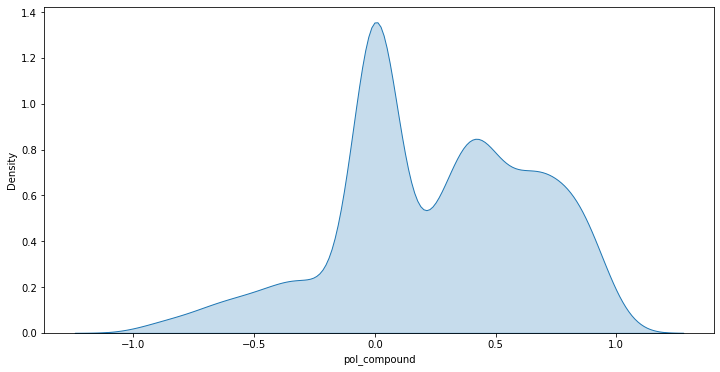

In [ ]:
# Plot the Compound Polarity description for ALL tweets in dataset

fig = plt.figure(figsize=(12, 6))
sns.distplot(combined_df['pol_compound'], hist=False, kde_kws={"shade": True})

In [ ]:
combined_df.iloc[0]['ner_terms']

['tesla', 'spacex', 'neuralink &amp', 'boring co']

In [ ]:
'tesla' in combined_df.iloc[0]['ner_terms']

True

# Sentiment Analysis of Tweets by NER

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


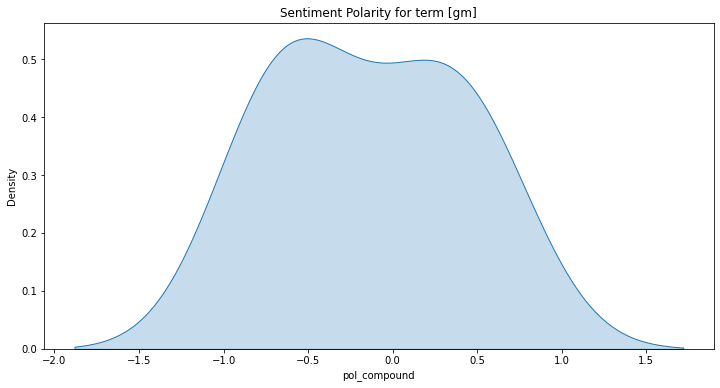

In [ ]:
# Plot the Compound Polarity description for ONLY tweets with 

# CUSTOMIZE: set aner to a topic word you want to find the sentiment for
aner = 'gm'

title_str = f"Sentiment Polarity for term [{aner}]"
subset_idx = combined_df['ner_terms'].apply(lambda nerterms : aner in nerterms)

fig = plt.figure(figsize=(12, 6))
plt.title(title_str)
sns.distplot(combined_df[subset_idx]['pol_compound'], hist=False, kde_kws={"shade": True})

### Sentiment Analysis of Tweet by Hashtag